In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

from numpy import array as arr

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import KFold
from torch.utils.data import ConcatDataset, DataLoader, Dataset, TensorDataset, random_split, SubsetRandomSampler
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = 'drive/My Drive/Colab Notebooks/2456_wind_project/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv(drive_path + "train.csv")
# df_test = pd.read_csv(drive_path + "train.csv")

In [ ]:
df_plant_1 = pd.read_csv(drive_path + "windforecasts_wf1.csv")
# df_plant_2 = pd.read_csv(drive_path + "windforecasts_wf2.csv")
# df_plant_3 = pd.read_csv(drive_path + "windforecasts_wf3.csv")
# df_plant_4 = pd.read_csv(drive_path + "windforecasts_wf4.csv")
# df_plant_5 = pd.read_csv(drive_path + "windforecasts_wf5.csv")
# df_plant_6 = pd.read_csv(drive_path + "windforecasts_wf6.csv")
# df_plant_7 = pd.read_csv(drive_path + "windforecasts_wf7.csv")

In [ ]:
# wind power measurments - from the original dataset solutions !!!

In [ ]:
# df_1_processed = pd.read_csv(drive_path + 'wp1_extracted_forecast.csv', index_col = 0)

# Hidden stuff

## examining the data

In [ ]:
data_string = "2009070112"
pd.to_datetime(data_string, format='%Y%m%d%H')

Timestamp('2009-07-01 12:00:00')

In [ ]:
df_working = df_plant_1
df_working["date"] = pd.to_datetime(df_working["date"], format='%Y%m%d%H')
df_working = df_working.set_index("date")
df_working = df_working.rename(columns = {"hors": "hours"}).rename_axis(None)

In [ ]:
END_DATE = pd.to_datetime("2011-01-01-00")
HOURS_OF_INTEREST = np.arange(1, 13, 1)
data_range_included_explanatory_variables = pd.date_range(
    start = df_working.index[0], end = END_DATE, freq='12h')
df_working = df_working \
    .loc[df_working.index.isin(data_range_included_explanatory_variables)]

In [ ]:
x_toy = np.hstack((np.repeat(1, 48), np.repeat(2, 48), np.repeat(3, 48), np.repeat(4, 48)))
addition = 1
index_forecasted_weather = np.hstack(np.repeat(x_toy[None, :], df_working.shape[0] / (48*4) + addition, axis = 0))
index_forecasted_weather = index_forecasted_weather[0: df_working.shape[0]]
df_working.loc[:, "index_forecasted_weather"] = index_forecasted_weather

In [ ]:
index_to_be_incremented = df_working.index
new_index = list()
index_shape = index_to_be_incremented.shape[0]
for addition, i in zip(df_working.hours.to_numpy(), range(index_shape)):
    new_index.append(index_to_be_incremented[i] + pd.Timedelta(hours = addition))
new_index = pd.to_datetime(new_index)

In [ ]:
df_working.index = new_index

In [ ]:
df_working_ws = df_working.loc[:, ["hours", "ws", "index_forecasted_weather"]]
df_working_wd = df_working.loc[:, ["hours", "wd", "index_forecasted_weather"]]

pivoted_ws = df_working_ws.reset_index().pivot(index="index", columns="index_forecasted_weather",
                              values="ws").rename(columns = {1: "ws_1", 2: "ws_2", 3: "ws_3", 4: "ws_4"})
pivoted_wd = df_working_wd.reset_index().pivot(index="index", columns="index_forecasted_weather",
                              values="wd").rename(columns = {1: "wd_1", 2: "wd_2", 3: "wd_3", 4: "wd_4"})

result = pivoted_ws.merge(pivoted_wd, how='inner', on='index').rename_axis(None, axis = 1).rename_axis(None)\
    .assign(
        wd_sin_1 = lambda df: np.sin(df.wd_1 * (2*np.pi / 360)),
        wd_cos_1 = lambda df: np.cos(df.wd_1 * (2*np.pi / 360)),
        wd_sin_2 = lambda df: np.sin(df.wd_2 * (2*np.pi / 360)),
        wd_cos_2 = lambda df: np.cos(df.wd_2 * (2*np.pi / 360)),
        wd_sin_3 = lambda df: np.sin(df.wd_3 * (2*np.pi / 360)),
        wd_cos_3 = lambda df: np.cos(df.wd_3 * (2*np.pi / 360)),
        wd_sin_4 = lambda df: np.sin(df.wd_4 * (2*np.pi / 360)),
        wd_cos_4 = lambda df: np.cos(df.wd_4 * (2*np.pi / 360)),
    ).drop(columns = ["wd_1", "wd_2", "wd_3", "wd_4"])
# result.head()

### Adding the observed power to the result data frame

In [ ]:
df_working_train = df_train
df_working_train["date"] = pd.to_datetime(df_working_train["date"], format='%Y%m%d%H')
df_working_train = df_working_train.set_index("date")
df_working_train = df_working_train.rename_axis(None)

In [ ]:
df_working_train.shape

(18757, 7)

In [ ]:
END_DATE_TRAIN = pd.to_datetime("2011-01-01-00")
data_range_included_response_variables = pd.date_range(
    start = df_working_train.index[0], end = END_DATE_TRAIN, freq='1h')
df_train_processed = df_working_train\
    .loc[df_working_train.index.isin(data_range_included_response_variables)]
df_train_processed.drop(df_train_processed.head(1).index, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Plotting wind speed for different predicitons

In [ ]:
# result["wp1"] = df_train_processed.loc[:, "wp1"]
# result = result.iloc[0:df_train_processed.shape[0], :]

In [ ]:
start_1 = 0
start_2 = 12
start_3 = 24
start_4 = 36

# TO DO: ADD JUMPS AUTOMIATICALLY
# HOWEVER, THE POINT IS CLEAR
# xcoords = [0.22058956, 0.33088437, 2.20589566]
# for xc in xcoords:
#     plt.axvline(x=xc)

PERIOD = 48
def print_stuff(input):
    start = input
    end  = start + 2
    result_plotting = result.iloc[PERIOD*start: PERIOD*end, :]
    # sns.set_theme(style=None)
    colors = ["red", "green", "blue", "orange"]

    fix, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 6))
    ax1.plot(result_plotting.index, result_plotting.ws_1, label = "ws_1", color = colors[0])
    ax1.plot(result_plotting.index, result_plotting.ws_2, label = "ws_2", color = colors[1])
    ax1.plot(result_plotting.index, result_plotting.ws_3, label = "ws_3", color = colors[2])
    ax1.plot(result_plotting.index, result_plotting.ws_4, label = "ws_4", color = colors[3])
    ax1.legend()
    ax1.tick_params(axis = "x", labelrotation=45)
    # for i in range():
    # ax1.axvline(x = result.index[start_1], color = colors[0])
    # ax1.axvline(x = result.index[start_2], color = colors[1])
    # ax1.axvline(x = result.index[start_3], color = colors[2])
    # ax1.axvline(x = result.index[start_4], color = colors[3])

    ax2.plot(result_plotting.index, result_plotting.wd_sin_1, label = "wd_sin_1", color = colors[0])
    ax2.plot(result_plotting.index, result_plotting.wd_sin_2, label = "wd_sin_2", color = colors[1])
    ax2.plot(result_plotting.index, result_plotting.wd_sin_3, label = "wd_sin_3", color = colors[2])
    ax2.plot(result_plotting.index, result_plotting.wd_sin_4, label = "wd_sin_4", color = colors[3])
    ax2.legend()
    ax2.tick_params(axis = "x", labelrotation=45)

    ax3.plot(result_plotting.index, result_plotting.wd_cos_1, label = "wd_cos_1", color = colors[0])
    ax3.plot(result_plotting.index, result_plotting.wd_cos_2, label = "wd_cos_2", color = colors[1])
    ax3.plot(result_plotting.index, result_plotting.wd_cos_3, label = "wd_cos_3", color = colors[2])
    ax3.plot(result_plotting.index, result_plotting.wd_cos_4, label = "wd_cos_4", color = colors[3])
    ax3.legend()
    ax3.tick_params(axis = "x", labelrotation=45)
    plt.show();

In [ ]:
# for i in range(0, 10, 1):
#     print_stuff(i*20)

## Previous preprocessing

In [ ]:
# def preprocessing_stage_1(df_plant_input):
#     def seperate_dates(df_input):
#         newdate_train = []
#         for i_date in range(len(df_input.date)):
#             datestr = str(df_input['date'][i_date])
#             date_form = datestr[:4]+'-'+ datestr[4:6]+'-'+ datestr[6:8] + '-' + datestr[8:10]
#             newdate_train.append(pd.to_datetime(date_form))

#         df_input['Date'] = newdate_train
#         df_input = df_input.set_index('Date')
#         return df_input

#     df_wind_farm_ = seperate_dates(df_plant_input)
#     df_train_ = seperate_dates(df_train)
#     df_wind_farm_ = df_wind_farm_.rename(columns = {"hors": "hours"})

#     END_DATE = pd.to_datetime("2010-12-31-12")
#     HOURS_OF_INTEREST = np.arange(1, 13, 1)
#     data_range_included_explanatory_variables = pd.date_range(
#         start = df_wind_farm_.index[0], end = END_DATE, freq='12h')
#     df_wind_farm_processed = df_wind_farm_ \
#         .loc[df_wind_farm_.index.isin(data_range_included_explanatory_variables)]\
#         .loc[lambda df: df.hours.isin(HOURS_OF_INTEREST)]

#     index_to_be_incremented = df_wind_farm_processed.index
#     new_index = list()
#     index_shape = index_to_be_incremented.shape[0]
#     for addition, i in zip(df_wind_farm_processed.hours.to_numpy(), range(index_shape)):
#         new_index.append(index_to_be_incremented[i] + pd.Timedelta(hours = addition))
#     new_index = pd.to_datetime(new_index)

#     df_wind_farm_processed.index = new_index
#     df_wind_farm_processed = df_wind_farm_processed.drop(columns = ["date", "hours"])
#     df_wind_farm_processed.drop(df_wind_farm_processed.tail(1).index, inplace=True)

#     END_DATE_TRAIN = pd.to_datetime("2010-12-31-23")
#     data_range_included_response_variables = pd.date_range(
#         start = df_train_.index[0], end = END_DATE_TRAIN, freq='1h')
#     df_train_processed = df_train_\
#         .loc[df_train_.index.isin(data_range_included_response_variables)]
#     df_train_processed.drop(df_train_processed.head(1).index, inplace=True)

#     df_wind_farm_processed["wp1"] = df_train_processed.wp1

#     return df_wind_farm_processed

In [ ]:
# def preprocessing_stage_2(df_preprocessed_farm):
#     df_preprocessed_farm_output = df_preprocessed_farm.assign(ws_sqrt = lambda df: np.sqrt(df_preprocessed_farm.ws),
#                                                wd_sin = lambda df: np.sin(df_preprocessed_farm.wd * (2*np.pi / 360)),
#                                                wd_cos = lambda df: np.cos(df_preprocessed_farm.wd * (2*np.pi / 360)),
#                                                ).drop(columns = ["u", "v", "wd"])
#     return df_preprocessed_farm_output

In [ ]:
# def preprocessing(df_farm_input):
#     df_preprocessed_farm = preprocessing_stage_1(df_farm_input)
#     df_preprocessed_ouput = preprocessing_stage_2(df_preprocessed_farm)

In [ ]:
# df_1_processed = preprocessing_stage_1(df_plant_1)
# df_2_processed = preprocessing_stage_1(df_plant_2)

In [ ]:
# df_1_processed = preprocessing_stage_2(df_1_processed)
# df_2_processed = preprocessing_stage_2(df_2_processed)

In [ ]:
# df_1_processed.to_csv(drive_path + 'wp1_extracted_forecast.csv')
# df_2_processed.to_csv(drive_path + 'wp2_extracted_forecast.csv')

In [ ]:
df_1_processed = pd.read_csv(drive_path + 'wp1_extracted_forecast.csv', index_col = 0)
df_2_processed = pd.read_csv(drive_path + 'wp2_extracted_forecast.csv', index_col = 0)
df_1_processed_final = pd.read_csv(drive_path + 'df_plant_1_processed_final.csv', index_col = 0)

In [ ]:
df_1_processed.shape

(13175, 5)

In [ ]:
df_1_processed_final

,hours,u,v,ws,wd_sin,wd_cos,month_sin,month_cos,wp1,index_forecasted_weather
2009-07-01 01:00:00,1,2.34,-0.79,2.47,0.947322,-0.320282,1.224647e-16,-1.000000,0.085,1
2009-07-01 02:00:00,2,2.18,-0.99,2.40,0.911331,-0.411673,1.224647e-16,-1.000000,0.020,1
2009-07-01 03:00:00,3,2.20,-1.21,2.51,0.877062,-0.480377,1.224647e-16,-1.000000,0.060,1
2009-07-01 04:00:00,4,2.35,-1.40,2.73,0.858423,-0.512942,1.224647e-16,-1.000000,0.045,1
2009-07-01 05:00:00,5,2.53,-1.47,2.93,0.864889,-0.501964,1.224647e-16,-1.000000,0.035,1
...,...,...,...,...,...,...,...,...,...,...
2010-12-31 20:00:00,44,2.66,4.18,4.95,0.537300,0.843391,-5.000000e-01,0.866025,0.536,3
2010-12-31 21:00:00,45,2.56,3.99,4.74,0.540387,0.841416,-5.000000e-01,0.866025,0.662,3
2010-12-31 22:00:00,46,2.74,4.13,4.96,0.553101,0.833114,-5.000000e-01,0.866025,0.817,3
2010-12-31 23:00:00,47,3.04,4.46,5.40,0.563238,0.826295,-5.000000e-01,0.866025,0.677,3


## EDA

In [ ]:
df_1_processed.head()

,ws,wp1,ws_sqrt,wd_sin,wd_cos
2009-07-01 01:00:00,2.47,0.085,1.571623,0.947322,-0.320282
2009-07-01 02:00:00,2.40,0.020,1.549193,0.911331,-0.411673
2009-07-01 03:00:00,2.51,0.060,1.584298,0.877062,-0.480377
2009-07-01 04:00:00,2.73,0.045,1.652271,0.858423,-0.512942
2009-07-01 05:00:00,2.93,0.035,1.711724,0.864889,-0.501964


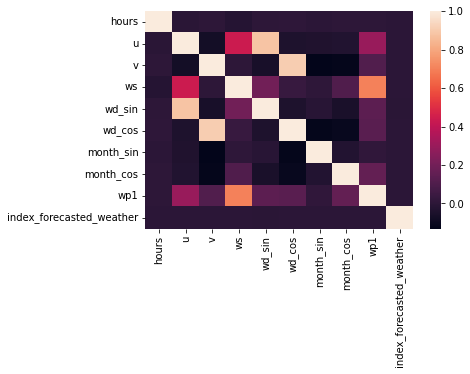

In [ ]:
sns.heatmap(df_1_processed_final.corr())

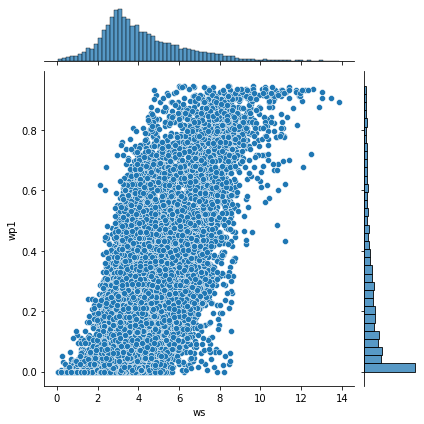

In [ ]:
sns.jointplot(data=df_1_processed, x="ws", y="wp1")

In [ ]:
from scipy import stats
import statsmodels.api as sm_api
# xt, lambda_boxcox = stats.boxcox(df_1_processed.wp1)

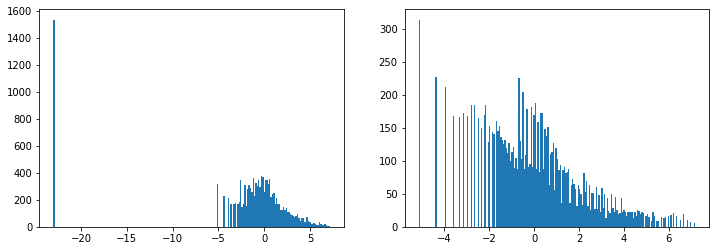

In [ ]:
def transformation(lambda_, y):
    epsilon = 1e-10
    y = np.where(y > 0, y, epsilon)
    return np.log((y**lambda_) / (1 - y**lambda_)) / lambda_

y_transformed = transformation(0.5, df_1_processed.wp1)
y_transformed_fake = transformation(0.5, df_1_processed.wp1[df_1_processed.wp1 > 0])

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].hist(y_transformed, bins = 200);
ax[1].hist(y_transformed_fake, bins = 200);

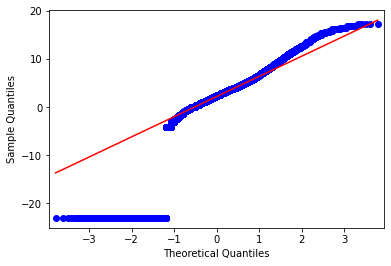

In [ ]:
sm_api.qqplot(transformation(0.25, df_1_processed.wp1), line = "q");

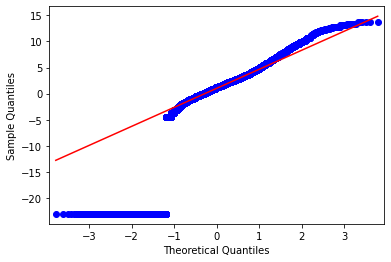

In [ ]:
sm_api.qqplot(transformation(0.3, df_1_processed.wp1), line = "q");

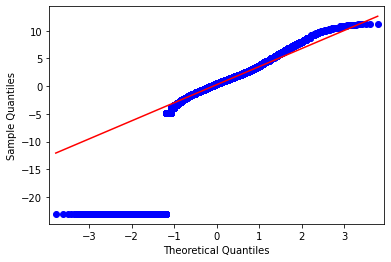

In [ ]:
sm_api.qqplot(transformation(0.35, df_1_processed.wp1), line = "q");

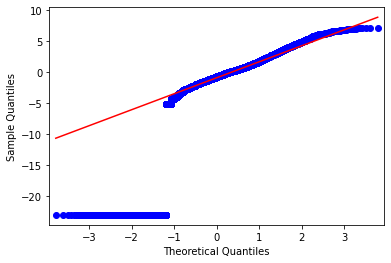

In [ ]:
sm_api.qqplot(transformation(0.5, df_1_processed.wp1), line = "q");

In [ ]:
np.min(y_transformed), np.max(y_transformed)

(-23.02251592882851, 13.687173623104671)

In [ ]:
y_transformed_mixmax = (y_transformed - np.min(y_transformed)) / (np.max(y_transformed) - np.min(y_transformed))

In [ ]:
np.min(y_transformed_mixmax), np.max(y_transformed_mixmax)

(0.0, 1.0)

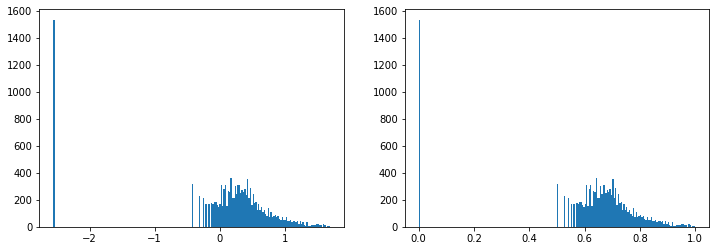

In [ ]:
y_transformed_standarized = (y_transformed - np.mean(y_transformed)) / np.std(y_transformed)
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].hist(y_transformed_standarized, bins = 200);
ax[1].hist(y_transformed_mixmax, bins = 200);

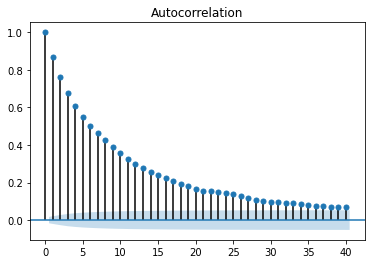

In [ ]:
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(y_transformed_standarized, lags=40)
plt.show()

## Other checking

In [ ]:
df_1_playing_trans = df_1_processed

In [ ]:
df_1_playing_trans.columns

Index(['ws', 'wp1', 'ws_sqrt', 'wd_sin', 'wd_cos'], dtype='object')

In [ ]:
# df_1_playing_trans = df_1_playing_trans.assign(ws_sqrt = lambda df: np.sqrt(df_1_playing_trans.ws),
#                                                wd_sin = lambda df: np.sin(df_1_playing_trans.wd * (2*np.pi / 360)),
#                                                wd_cos = lambda df: np.cos(df_1_playing_trans.wd * (2*np.pi / 360)),
#                                                ).drop(columns = ["u", "v", "wd"])

AttributeError: ignored

In [ ]:
df_1_playing_trans.head()

,ws,wp1,ws_sqrt,wd_sin,wd_cos
2009-07-01 01:00:00,2.47,0.085,1.571623,0.947322,-0.320282
2009-07-01 02:00:00,2.40,0.020,1.549193,0.911331,-0.411673
2009-07-01 03:00:00,2.51,0.060,1.584298,0.877062,-0.480377
2009-07-01 04:00:00,2.73,0.045,1.652271,0.858423,-0.512942
2009-07-01 05:00:00,2.93,0.035,1.711724,0.864889,-0.501964


In [ ]:
plt.hist(df_1_playing_trans.wd, bins = 100);

AttributeError: ignored

In [ ]:
from sklearn import preprocessing
# Normalizer_toy = preprocessing.Normalizer(norm = "max").fit_transform(df_1_playing_trans.ws.to_numpy().reshape(-1, 1))
Normalizer_toy = preprocessing.Normalizer(norm = "max").fit_transform(df_1_playing_trans.ws.to_numpy().reshape(1, -1))

In [ ]:
np.max(df_1_playing_trans.ws)

13.89

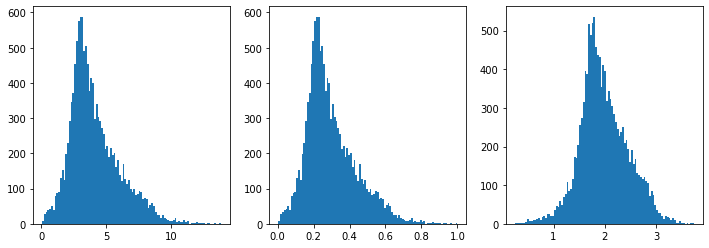

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax[0].hist(df_1_playing_trans.ws, bins = 100);
ax[1].hist(np.squeeze(Normalizer_toy), bins = 100);
ax[2].hist(np.sqrt(df_1_playing_trans.ws), bins = 100);

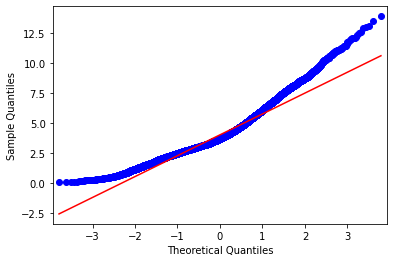

In [ ]:
sm_api.qqplot(df_1_playing_trans.ws, line = "q");

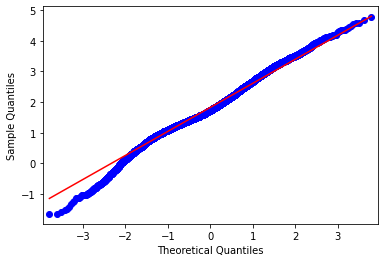

In [ ]:
xt, lambda_boxcox = stats.boxcox(df_1_playing_trans.ws)
sm_api.qqplot(xt, line = "q");

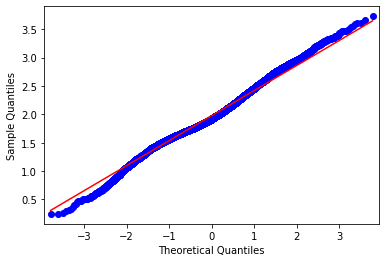

In [ ]:
sm_api.qqplot(np.sqrt(df_1_playing_trans.ws), line = "q");

## Creating the lag - wrong

In [ ]:
df_1_processed_playing = df_1_processed[0:500]

In [ ]:
def split_datasets_wrong(df, window_size, offset = 1, n_future_predictions = 1):
  X = []
  y = []
  for ii in range(0,len(df)-window_size+1, offset):
    sample = df[ii:window_size+ii]
    target = sample["wp1"].values[-n_future_predictions]
    sample = sample.drop(labels=["wp1"], axis=1)
    X.append(sample.values)
    y.append(target)
  return arr(X), arr(y)

In [ ]:
WINDOW_SIZE = 100
X, y = split_datasets_wrong(df_1_processed_playing, WINDOW_SIZE)

In [ ]:
X.shape

In [ ]:
X[0][-3:], y[0]

In [ ]:
df_1_processed_playing[97:100]

In [ ]:
df_1_processed_playing.tail(2)

In [ ]:
X[-1][-3:], y[-1]

## Creating the datasets - correct

In [ ]:
def split_datasets_correct(df, window_size, offset = 1, n_future_predictions = 1):
  X_previous = []
  X_current = []
  y = []
  for ii in range(0,len(df)- window_size + 1 - n_future_predictions, offset):
    X_previous.append(df[ii:window_size+ii].values)
    current = df.iloc[window_size+ii: window_size + ii + n_future_predictions, :]
    target = current["wp1"].values
    current = current.drop(labels=["wp1"], axis=1)
    X_current.append(current)
    y.append(target)
  return arr(X_previous), arr(X_current), arr(y)[:, None]

In [ ]:
X_previous, X_currect, y_ = split_datasets_correct(df_1_processed_playing, WINDOW_SIZE,
                                                   n_future_predictions = 2)

In [ ]:
X_previous.shape, X_currect.shape, y_.shape

In [ ]:
df_1_processed_playing[97:102]

In [ ]:
X_previous[0][-3:], X_currect[0], y_[0]

In [ ]:
class Dataset_correct_one_farm(torch.utils.data.Dataset):
    def __init__(self, X_previous, X_currect, y_ ):
        self.X_previous_ndarray = X_previous
        self.X_current_ndarray = X_currect
        self.y_ndarray = y_

    def __len__(self):
        return len(self.xList)

    def __getitem__(self, index):
        X_previous = self.X_previous_ndarray[index]
        X_currect = self.X_current_ndarray[index]
        y_ = self.y_ndarray

        return X_previous, X_currect, y_ 

In [ ]:
dataset_farm_1 = Dataset_correct_one_farm(X_previous, X_currect, y_ )

# Correct stuff

## Creating the lag - CORRECT UPDATED AFTER TALKING WITH THE TA
when we want to predict the next 48h and we are at 0 or 12 we have 48h of weather forecast at our disposal. However, if we get to the 7am we only have 48h - 7h = 41h of weather forecast since the next forecast comes at 12am. 

**Solution**: add 0 at the end to ensure that every weather forecast has length 48 and then during training use padding on them. It will result in LSTM not taking them into consideration when doing backpropagation through time.

In [ ]:
df_working["wp1"] = df_train_processed.loc[:, "wp1"]

In [ ]:
result = list()
unique_index = np.unique(df_working.index)
for index_elem in unique_index:
    array_toy = df_working.loc[df_working.index == index_elem].wp1.values
    result.append(np.unique(array_toy).shape[0] == 1)
result = np.array(result)
assert np.all(result == True)

In [ ]:
df_working.index.month

Int64Index([7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
            ...
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
           dtype='int64', length=52752)

In [ ]:
df_working.head()

,hours,u,v,ws,wd,index_forecasted_weather,wp1
2009-07-01 01:00:00,1,2.34,-0.79,2.47,108.68,1,0.085
2009-07-01 02:00:00,2,2.18,-0.99,2.40,114.31,1,0.020
2009-07-01 03:00:00,3,2.20,-1.21,2.51,118.71,1,0.060
2009-07-01 04:00:00,4,2.35,-1.40,2.73,120.86,1,0.045
2009-07-01 05:00:00,5,2.53,-1.47,2.93,120.13,1,0.035


In [ ]:
df_working = df_working.assign(
        wd_sin = lambda df: np.sin(df.wd * (2*np.pi / 360)),
        wd_cos = lambda df: np.cos(df.wd * (2*np.pi / 360)),
        month_sin = lambda df: np.sin((df.index.month - 1) * (2*np.pi / 12)),
        month_cos = lambda df: np.cos((df.index.month - 1) * (2*np.pi / 12)),
        hour_sin = lambda df: np.sin((df.index.hour) * (2*np.pi / 24)),
        hour_cos = lambda df: np.cos((df.index.hour) * (2*np.pi / 24))
    ).drop(columns = ["wd"])

In [ ]:
df_working.head()

,hours,u,v,ws,index_forecasted_weather,wp1,wd_sin,wd_cos,month_sin,month_cos,hour_sin,hour_cos
2009-07-01 01:00:00,1,2.34,-0.79,2.47,1,0.085,0.947322,-0.320282,1.224647e-16,-1.0,0.258819,0.965926
2009-07-01 02:00:00,2,2.18,-0.99,2.40,1,0.020,0.911331,-0.411673,1.224647e-16,-1.0,0.500000,0.866025
2009-07-01 03:00:00,3,2.20,-1.21,2.51,1,0.060,0.877062,-0.480377,1.224647e-16,-1.0,0.707107,0.707107
2009-07-01 04:00:00,4,2.35,-1.40,2.73,1,0.045,0.858423,-0.512942,1.224647e-16,-1.0,0.866025,0.500000
2009-07-01 05:00:00,5,2.53,-1.47,2.93,1,0.035,0.864889,-0.501964,1.224647e-16,-1.0,0.965926,0.258819


In [ ]:
df_working_updated = df_working[df_working.index.isin(data_range_included_response_variables)]
df_working_updated.loc[df_working_updated.index == END_DATE_TRAIN]

,hours,u,v,ws,index_forecasted_weather,wp1,wd_sin,wd_cos,month_sin,month_cos,hour_sin,hour_cos
2011-01-01,48,3.20,4.72,5.70,3,0.551,0.561650,0.827375,0.0,1.0,0.0,1.0
2011-01-01,36,3.16,4.10,5.18,4,0.551,0.610698,0.791863,0.0,1.0,0.0,1.0
2011-01-01,24,3.61,4.67,5.90,1,0.551,0.611251,0.791437,0.0,1.0,0.0,1.0
2011-01-01,12,3.46,4.87,5.98,2,0.551,0.579281,0.815128,0.0,1.0,0.0,1.0


In [ ]:
FILTER_UNTIL = df_working_updated.reset_index().loc[df_working_updated.index == END_DATE_TRAIN].index[0]
df_working_updated = df_working_updated.iloc[0:FILTER_UNTIL + 1, :]

list_toy = df_working_updated.columns.values.tolist()
list_always = ['wp1', 'index_forecasted_weather']
item_list = [item for item in list_toy if item not in list_always]
df_working_updated = df_working_updated.filter([*item_list, *list_always])
print(df_working_updated.shape[0] / 48)

1095.0


## Transformations

In [ ]:
df_working_updated.head()

,hours,u,v,ws,wd_sin,wd_cos,month_sin,month_cos,hour_sin,hour_cos,wp1,index_forecasted_weather
2009-07-01 01:00:00,1,2.34,-0.79,2.47,0.947322,-0.320282,1.224647e-16,-1.0,0.258819,0.965926,0.085,1
2009-07-01 02:00:00,2,2.18,-0.99,2.40,0.911331,-0.411673,1.224647e-16,-1.0,0.500000,0.866025,0.020,1
2009-07-01 03:00:00,3,2.20,-1.21,2.51,0.877062,-0.480377,1.224647e-16,-1.0,0.707107,0.707107,0.060,1
2009-07-01 04:00:00,4,2.35,-1.40,2.73,0.858423,-0.512942,1.224647e-16,-1.0,0.866025,0.500000,0.045,1
2009-07-01 05:00:00,5,2.53,-1.47,2.93,0.864889,-0.501964,1.224647e-16,-1.0,0.965926,0.258819,0.035,1


In [ ]:
# def transformation(lambda_, y):
#     epsilon = 1e-10
#     y = np.where(y > 0, y, epsilon)
#     return np.log((y**lambda_) / (1 - y**lambda_)) / lambda_

# y_transformed = transformation(0.5, df_working_updated.wp1)
# y_transformed_mixmax = (y_transformed - np.min(y_transformed)) / (np.max(y_transformed) - np.min(y_transformed))

In [ ]:
ws_transformed = np.sqrt(df_working_updated.ws)
df_working_updated["ws"] = ws_transformed
# df_working_updated["wp1"] = y_transformed_mixmax
df_working_updated.head()

,hours,u,v,ws,wd_sin,wd_cos,month_sin,month_cos,hour_sin,hour_cos,wp1,index_forecasted_weather
2009-07-01 01:00:00,1,2.34,-0.79,1.571623,0.947322,-0.320282,1.224647e-16,-1.0,0.258819,0.965926,0.085,1
2009-07-01 02:00:00,2,2.18,-0.99,1.549193,0.911331,-0.411673,1.224647e-16,-1.0,0.500000,0.866025,0.020,1
2009-07-01 03:00:00,3,2.20,-1.21,1.584298,0.877062,-0.480377,1.224647e-16,-1.0,0.707107,0.707107,0.060,1
2009-07-01 04:00:00,4,2.35,-1.40,1.652271,0.858423,-0.512942,1.224647e-16,-1.0,0.866025,0.500000,0.045,1
2009-07-01 05:00:00,5,2.53,-1.47,1.711724,0.864889,-0.501964,1.224647e-16,-1.0,0.965926,0.258819,0.035,1


In [ ]:
mean_ws = np.mean(df_working_updated["ws"]); std_ws = np.std(df_working_updated["ws"])
mean_wd_sin = np.mean(df_working_updated["wd_sin"]); std_wd_sin = np.std(df_working_updated["wd_sin"])
mean_wd_cos = np.mean(df_working_updated["wd_cos"]); std_wd_cos = np.std(df_working_updated["wd_cos"])
mean_u = np.mean(df_working_updated["u"]); std_u = np.std(df_working_updated["u"])
mean_v = np.mean(df_working_updated["v"]); std_v = np.std(df_working_updated["v"])
mean_month_sin = np.mean(df_working_updated["month_sin"]); std_month_sin = np.std(df_working_updated["month_sin"])
mean_month_cos = np.mean(df_working_updated["month_cos"]); std_month_cos = np.std(df_working_updated["month_cos"])
mean_hour_sin = np.mean(df_working_updated["hour_sin"]); std_hour_sin = np.std(df_working_updated["hour_sin"])
mean_hour_cos = np.mean(df_working_updated["hour_cos"]); std_hour_cos = np.std(df_working_updated["hour_cos"])

In [ ]:
df_working_updated["ws"] = (df_working_updated["ws"] - mean_ws) / std_ws
df_working_updated["wd_sin"] = (df_working_updated["wd_sin"] - mean_wd_sin) / std_wd_sin
df_working_updated["wd_cos"] = (df_working_updated["wd_cos"] - mean_wd_cos) / std_wd_cos
df_working_updated["u"] = (df_working_updated["u"] - mean_u) / std_u
df_working_updated["v"] = (df_working_updated["v"] - mean_v) / std_v
df_working_updated["month_sin"] = (df_working_updated["month_sin"] - mean_month_sin) / std_month_sin
df_working_updated["month_cos"] = (df_working_updated["month_cos"] - mean_month_cos) / std_month_cos
df_working_updated["hour_sin"] = (df_working_updated["hour_sin"] - mean_hour_sin) / std_hour_sin
df_working_updated["hour_cos"] = (df_working_updated["hour_cos"] - mean_hour_cos) / std_hour_cos

In [ ]:
df_working_updated.head()

,hours,u,v,ws,wd_sin,wd_cos,month_sin,month_cos,hour_sin,hour_cos,wp1,index_forecasted_weather
2009-07-01 01:00:00,1,0.233662,-0.198982,-0.862185,0.928484,-0.382437,0.310662,-1.335029,0.366025,1.366025,0.085,1
2009-07-01 02:00:00,2,0.181121,-0.268072,-0.910722,0.873757,-0.518663,0.310662,-1.335029,0.707107,1.224745,0.020,1
2009-07-01 03:00:00,3,0.187689,-0.344071,-0.834758,0.821647,-0.621071,0.310662,-1.335029,1.000000,1.000000,0.060,1
2009-07-01 04:00:00,4,0.236946,-0.409707,-0.687669,0.793305,-0.669613,0.310662,-1.335029,1.224745,0.707107,0.045,1
2009-07-01 05:00:00,5,0.296054,-0.433888,-0.559017,0.803136,-0.653249,0.310662,-1.335029,1.366025,0.366025,0.035,1


In [ ]:
HOURS_OF_INTEREST = np.arange(1, 13, 1)
df_working_sliding_window = df_working_updated \
    .loc[lambda df: df.hours.isin(HOURS_OF_INTEREST)]

In [ ]:
# it's for the sliding window so it doesn't have to be to the very end
print(df_working_sliding_window.index.is_unique)
df_working_sliding_window.tail()

True


,hours,u,v,ws,wd_sin,wd_cos,month_sin,month_cos,hour_sin,hour_cos,wp1,index_forecasted_weather
2010-12-30 08:00:00,8,0.207391,1.538628,0.482800,0.203273,1.410349,-0.429685,1.31365,1.224745e+00,-0.707107,0.015,3
2010-12-30 09:00:00,9,0.062905,1.618082,0.487731,0.062043,1.475259,-0.429685,1.31365,1.000000e+00,-1.000000,0.020,3
2010-12-30 10:00:00,10,-0.045460,1.576628,0.378044,-0.020466,1.505531,-0.429685,1.31365,7.071068e-01,-1.224745,0.045,3
2010-12-30 11:00:00,11,-0.098001,1.493720,0.234575,-0.042371,1.512685,-0.429685,1.31365,3.660254e-01,-1.366025,0.045,3
2010-12-30 12:00:00,12,-0.061879,1.476447,0.229367,-0.005424,1.500408,-0.429685,1.31365,1.602146e-16,-1.414214,0.065,3


In [ ]:
# SAVING DATAFRAMES
df_working_updated.to_csv(drive_path + 'df_plant_1_processed_final_changed.csv')
df_working_sliding_window.to_csv(drive_path + 'df_plant_1_processed_sliding_window_changed.csv')

In [ ]:
# BATCHES_EXCLUDED = 5
# WINDOW_SIZE = 12*BATCHES_EXCLUDED

# INTERVAL = 48
# TIMES_ONE_DATASET = 12
# NUMBER_OF_48_PERIODS = int(df_working_updated.shape[0] / INTERVAL)
# MORE_DATA_FOR_TRAINING = 12
# PADDED_VALUE = -10

# result = []
# result_target = []

# list_of_df_sliding_global = []
# list_of_last_wp_global = []
# list_of_current = []

# window_size = WINDOW_SIZE
# for i in range(NUMBER_OF_48_PERIODS - BATCHES_EXCLUDED):
#     iterator = i + BATCHES_EXCLUDED
#     df_temp = df_working_updated.iloc[INTERVAL*iterator: INTERVAL*(iterator+1), :]
#     assert np.unique(df_temp.loc[:, "index_forecasted_weather"].values).shape[0] == 1
#     array_values = df_temp.drop(columns = ["index_forecasted_weather", "hours"]).values

#     end_sliding_window = df_temp.index[0] - pd.Timedelta(hours = 1)
#     start_sliding_window = df_temp.index[0] - pd.Timedelta(hours = window_size)
#     # MORE DATA FOR TRAINING
#     end_sliding_window = end_sliding_window + pd.Timedelta(hours = MORE_DATA_FOR_TRAINING)
#     df_window = df_working_sliding_window.loc[start_sliding_window:end_sliding_window, :]
#     df_window = df_window.drop(columns = ["index_forecasted_weather", "hours"])

#     target_list = array_values[:, array_values.shape[1] - 1][:, None]
#     target_list_padded_values = np.full((array_values.shape[0] + 12, 1), fill_value = PADDED_VALUE)
#     final_target_list = np.vstack((target_list, target_list_padded_values))

#     explanatory_list = array_values[:, 0:(array_values.shape[1] - 1)]
#     explanatory_list_padded_value = np.full((12, array_values.shape[1] - 1), fill_value = PADDED_VALUE)
#     final_explanatory_list = np.vstack((explanatory_list, explanatory_list_padded_value))

#     list_of_df_sliding = []
#     list_of_last_wp = []
#     explanatory_48_hours = []
#     target_48_hours = []
#     for j in range(MORE_DATA_FOR_TRAINING):
#         df_sliding_tmp = df_window.iloc[j:j+window_size, :]
#         list_of_df_sliding.append(df_sliding_tmp.values)
#         # PROBLEM HERE WHEN SCALING - WP1 NEEDS TO BE CHANGE FOR WP
#         list_of_last_wp.append(df_sliding_tmp.wp1[-1])
#         explanatory_48_hours.append(final_explanatory_list[j:j+INTERVAL, :])
#         target_48_hours.append(final_target_list[j:j+INTERVAL, :])

#     result.append(explanatory_48_hours)
#     result_target.append(target_48_hours)

#     list_of_df_sliding = arr(list_of_df_sliding)
#     list_of_last_wp = arr(list_of_last_wp)

#     list_of_df_sliding_global.append(list_of_df_sliding)
#     list_of_last_wp_global.append(list_of_last_wp)

# list_of_df_sliding_global = arr(list_of_df_sliding_global)
# list_of_last_wp_global = arr(list_of_last_wp_global)[:, :, None, None]
# result = arr(result)
# result_target = arr(result_target)

# print(list_of_df_sliding_global.shape, list_of_last_wp_global.shape, result.shape, result_target.shape)

(1093, 12, 60, 8) (1093, 12, 1, 1) (1093, 12, 48, 7) (1093, 12, 48, 1)


In [ ]:
df_temp.index

DatetimeIndex(['2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-

Everything is corrected, it was checked but not included here

### Checking the padding, in the loss function the output needs to be masked out

In [ ]:
seed_value = 12321
torch.manual_seed(seed_value)
np.random.seed(seed_value)

In [ ]:
lstm = nn.LSTM(1, 5, 2, batch_first = True)
input_data = arr([[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 0, 0]])
input_data_2 = arr([[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 0, 0]])
input = torch.Tensor(input_data)[:, :, None]
input_2 = torch.Tensor(input_data)[:, :, None]
print(input.shape)
input_packed = torch.nn.utils.rnn.pack_padded_sequence(input, lengths = arr([6, 4]), batch_first=True)
input_packed_2 = torch.nn.utils.rnn.pack_padded_sequence(input_2, lengths = arr([6, 6]), batch_first=True)
input_packed.data.shape, input_packed.batch_sizes

In [ ]:
output, (hn, cn) = lstm(input_packed)
output_2, (hn, cn) = lstm(input_packed_2)

In [ ]:
print(output.data.shape, output_2.data.shape)

In [ ]:
unpacked_1 = nn.utils.rnn.pad_packed_sequence(output, batch_first = True)[0]
unpacked_2 = nn.utils.rnn.pad_packed_sequence(output_2, batch_first = True)[0]
unpacked_1.shape

In [ ]:
unpacked_1[1, :, :].flatten()

In [ ]:
linear_1 = nn.Linear(unpacked_1[1, :, :].flatten().shape[0], 1)
linear_2 = nn.Linear(unpacked_1[1, :, :].flatten().shape[0] - 2*5, 1)
print(linear_2)

In [ ]:
for p in linear_1.parameters():
    if p.requires_grad:
         print(p.name, p.data)

In [ ]:
for p in linear_2.parameters():
    if p.requires_grad:
         print(p.name, p.data)

In [ ]:
linear_1(unpacked_1[1, :, :].flatten())

In [ ]:
linear_2(unpacked_1[1, 0:4, :].flatten())

In [ ]:
unpacked_1[1, 0:4, :]

### Other stuff

In [ ]:
TEST_SET_PERCENT = 0.1
VALIDATION_SET_PERCENT = 0.1

In [ ]:
TRUE_SIZE = NUMBER_OF_48_PERIODS - BATCHES_EXCLUDED
test_size = int(TRUE_SIZE * TEST_SET_PERCENT)
validation_size = int((TRUE_SIZE - test_size) * VALIDATION_SET_PERCENT)
train_size = TRUE_SIZE - validation_size - test_size
assert TRUE_SIZE == test_size + validation_size + train_size
train_size, validation_size, test_size

In [ ]:
sliding_window = list_of_df_sliding_global
X_encoder_decoder = list_of_last_wp_global
X = result
y = result_target

In [ ]:
SPECIAL = 3

sw_train = sliding_window[0:train_size - SPECIAL]
sw_train_special = sliding_window[train_size - SPECIAL:train_size]
sw_val = sliding_window[train_size: train_size + validation_size - SPECIAL, 0:1]
sw_val_special = sliding_window[train_size + validation_size - SPECIAL: train_size + validation_size, 0:1]
sw_test = sliding_window[train_size + validation_size:, 0:1]

X_ed_train = X_encoder_decoder[0:train_size - SPECIAL]
X_ed_train_special = X_encoder_decoder[train_size - SPECIAL:train_size]
X_ed_val = X_encoder_decoder[train_size: train_size + validation_size - SPECIAL, 0:1]
X_ed_val_special = X_encoder_decoder[train_size + validation_size - SPECIAL: train_size + validation_size, 0:1]
X_ed_test = X_encoder_decoder[train_size + validation_size:, 0:1]

X_train = X[0:train_size - SPECIAL]
X_train_special = X[train_size - SPECIAL:train_size]
X_val = X[train_size: train_size + validation_size - SPECIAL, 0:1]
X_val_special = X[train_size + validation_size - SPECIAL: train_size + validation_size, 0:1]
X_test = X[train_size + validation_size:, 0:1]

y_train = y[0:train_size - SPECIAL]
y_train_special = y[train_size - SPECIAL:train_size]
y_val = y[train_size: train_size + validation_size - SPECIAL, 0:1]
y_val_sepcial = y[train_size + validation_size - SPECIAL: train_size + validation_size, 0:1]
y_test = y[train_size + validation_size:, 0:1]

print(sw_train.shape, sw_train_special.shape, sw_val.shape, sw_val_special.shape, sw_test.shape)
print()
print(X_ed_train.shape, X_ed_train_special.shape, X_ed_val.shape, X_ed_val_special.shape, X_ed_test.shape)
print()
print(X_train.shape, X_train_special.shape, X_val.shape, X_val_special.shape, X_test.shape)
print()
print(y_train.shape, y_train_special.shape, y_val.shape, y_val_sepcial.shape, y_test.shape)

Evaluation and testing is not conducted on the additional data with padding, only on the full weather prediction, those will be prediction conditions

## DataLoaders Pytroch

In [ ]:
class Dataset_one_plant(torch.utils.data.Dataset):
    def __init__(self, sw, X_ed, X, y):
        self.sw = torch.from_numpy(sw).float()
        self.X_ed = torch.from_numpy(X_ed).float() 
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.sw.shape[0]

    def __getitem__(self, index):
        result_dict = {}
        result_dict["sw"] = self.sw[index]
        result_dict["X_ed"] = self.X_ed[index]
        result_dict["X"] = self.X[index]
        result_dict["y"] = self.y[index]
        return result_dict

In [ ]:
dataset_train = Dataset_one_plant(sw_train, X_ed_train, X_train, y_train)
dataset_train_special = Dataset_one_plant(sw_train_special, X_ed_train_special, X_train_special, y_train_special)
dataset_val = Dataset_one_plant(sw_val, X_ed_val, X_val, y_val)
dataset_val_special = Dataset_one_plant(sw_val_special, X_ed_val_special, X_val_special, y_val_sepcial)
dataset_test = Dataset_one_plant(sw_test, X_ed_test, X_test, y_test)

In [ ]:
BATCH_SIZE = 2
dataloader_train = DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = False)
dataloader_train_special = DataLoader(dataset_train_special, batch_size = BATCH_SIZE, shuffle = False)
dataloader_val = DataLoader(dataset_val, batch_size = BATCH_SIZE, shuffle = False)
dataloader_val_special = DataLoader(dataset_val_special, batch_size = BATCH_SIZE, shuffle = False)
dataloader_test = DataLoader(dataset_test, batch_size = BATCH_SIZE, shuffle = False)
print(len(dataloader_train), len(dataloader_train_special), len(dataloader_val),
      len(dataloader_val_special), len(dataloader_test))

other stuff

In [ ]:
def split_datasets_correct(df, window_size, offset = 1, n_future_predictions = 1):
  X_previous = []
  X_current = []
  y = []
  for ii in range(0,len(df)- window_size + 1 - n_future_predictions, offset):
    X_previous.append(df[ii:window_size+ii].values)
    current = df.iloc[window_size+ii: window_size + ii + n_future_predictions, :]
    target = current["wp1"].values
    current = current.drop(labels=["wp1"], axis=1)
    X_current.append(current)
    y.append(target)
  return arr(X_previous), arr(X_current), arr(y)[:, None]

In [ ]:
WINDOW_SIZE = 100
X_previous, X_currect, y_ = split_datasets_correct(df_1_processed, WINDOW_SIZE,
                                                   n_future_predictions = 1)
print(X_previous.shape, X_currect.shape, y_.shape)

In [ ]:
print(result.shape, df_1_processed.shape)

In [ ]:
x_optimal = np.hstack((np.repeat(1, 12), np.repeat(2, 12), np.repeat(3, 12), np.repeat(4, 12)))
addition = 1
x_optimal_list = np.hstack(np.repeat(x_optimal[None, :], result.shape[0] / (12*4) + addition, axis = 0))
x_optimal_list = x_optimal_list[0: result.shape[0]]
# df_working.loc[:, "index_forecasted_weather"] = index_forecasted_weather
result.loc[:, "optimal_plant"] = x_optimal_list

In [ ]:
result_playing = result
window_size = WINDOW_SIZE
n_future_predictions = 48
offset = 1

X_previous = []
X_current = []
y = []
for ii in range(0,len(result_playing)- window_size + 1 - n_future_predictions, offset):
    X_previous.append(df_1_processed[ii:window_size+ii].values)
    current = result_playing.iloc[window_size+ii: window_size + ii + n_future_predictions, :]
    target = current["wp1"].values
    current = current.drop(labels=["wp1"], axis=1)
    X_current.append(current)
    y.append(target)

## Including the second 1,5 years of data

In [ ]:
FIRST_NA = 52735
df_working_plant.iloc[FIRST_NA - 5: FIRST_NA + 100]

## MODELS AND HELPER FUNCTIONS

In [ ]:
def reset_weights(m):
  '''
 Reset model weights to avoid leakage of weights
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    layer.reset_parameters()

## Checking the article PhD

In [ ]:
df_toy_example = df_train.wp1

In [ ]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Time delay embedding
    Time series for supervised learning
    :param series: time series as pd.Series
    :param n_lags: number of past values to used as explanatory variables
    :param horizon: how many values to forecast
    :return: pd.DataFrame with reconstructed time series
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    X = [series.shift(i) for i in n_lags_iter]
    X = pd.concat(X, axis=1).dropna()
    X.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return X

In [ ]:
LAGS = 3
HORIZON = 2
# df_transformed_toy = time_delay_embedding(df_toy_example, LAGS, HORIZON)

In [ ]:
df_transformed_toy_2_columns = df_train[["wp1", "wp2", "wp3"]]

In [ ]:
wine_ds = []
for col in df_transformed_toy_2_columns:
    col_df = time_delay_embedding(df_transformed_toy_2_columns[col], n_lags = LAGS, horizon = HORIZON)
    wine_ds.append(col_df)

# concatenating all variables
wine_df = pd.concat(wine_ds, axis=1).dropna()

# defining target (Y) and explanatory variables (X)
predictor_variables = wine_df.columns.str.contains('\(t\-')
target_variables = wine_df.columns.str.contains('wp3\(t\+')

X = wine_df.iloc[:, predictor_variables]
Y = wine_df.iloc[:, target_variables]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor

# train/test split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [ ]:
# fitting a RF model
model = RandomForestRegressor()
model.fit(X_tr, Y_tr)

# getting forecasts for the test set
preds = model.predict(X_ts)

# computing MAE error
print(mae(Y_ts, preds))

## Playing with numpy dimensionsnumber_of_12h_periods

In [ ]:
x = np.arange(1, 21, 1)
x_3d = x.reshape((2, 2, 5))
x_2d = x.reshape((2, 10))
x_2d

In [ ]:
x_3d.reshape(2, 10)

In [ ]:
# INTERVAL = 48
# TIMES_ONE_DATASET = 12
# NUMBER_OF_48_PERIODS = int(df_working_updated.shape[0] / INTERVAL)
# PADDED_VALUE = -1

# result = []
# result_target = []
# for j in range(NUMBER_OF_48_PERIODS):
#     df_temp = df_working_updated.iloc[INTERVAL*j:INTERVAL*(j+1), :]
#     assert np.unique(df_temp.loc[:, "index_forecasted_weather"].values).shape[0] == 1
#     array_values = df_temp.drop(columns = ["index_forecasted_weather"]).values

#     target_list = array_values[:, array_values.shape[1] - 1][:, None]
#     final_target_list = np.zeros((array_values.shape[0] + 12, 1))
#     final_target_list[0:target_list.shape[0], :] = target_list

#     explanatory_list = array_values[:, 0:(array_values.shape[1] - 1)]
#     final_explanatory_list = np.zeros((array_values.shape[0] + 12, array_values.shape[1] - 1))
#     final_explanatory_list[0:array_values.shape[0], :] = explanatory_list

#     explanatory_48_hours = []
#     target_48_hours = []
#     for i in range(TIMES_ONE_DATASET):
#         explanatory_48_hours.append(final_explanatory_list[i:i+INTERVAL, :])
#         target_48_hours.append(final_target_list[i:i+INTERVAL, :])

#     result.append(explanatory_48_hours)
#     result_target.append(target_48_hours)

# result = arr(result)
# result_target = arr(result_target)
# result.shape, result_target.shape

In [ ]:
# def split_datasets_correct(df, window_size, offset = 1, n_future_predictions = 1):
#   X_previous = []
#   X_current = []
#   y = []
#   for ii in range(0,len(df)- window_size + 1 - n_future_predictions, offset):
#     X_previous.append(df[ii:window_size+ii].values)
#     current = df.iloc[window_size+ii: window_size + ii + n_future_predictions, :]
#     target = current["wp1"].values
#     current = current.drop(labels=["wp1"], axis=1)
#     X_current.append(current)
#     y.append(target)
#   return arr(X_previous), arr(X_current), arr(y)[:, None]